In [ ]:
%reload_ext autoreload
%autoreload 2

In [ ]:
!git clone https://github.com/Aryaa6603/Depth_Estimation_monocular.git
%cd /content/Depth/

### Install requirements for the project
You will be prompted to restart the runtime afterwards

In [ ]:
!pip install -r requirements.txt

Restart the runtime here! (`⌘/Ctrl + M .`)

In [ ]:
%cd /content/Depth/

### Pull DVC files from our remote

This step may take a few minutes

In [ ]:
!dvc pull -q -r origin src/data/processed/ src/models

## Testing setup
Run these 3 cells before going further in the testing section. They are not necessary for the training section

In [ ]:
import torch
import sys
from fastai.vision.all import *
import numpy as np

In [ ]:
class ImageImageDataLoaders(DataLoaders):
    """Basic wrapper around several `DataLoader`s with factory methods for Image to Image problems"""
    @classmethod
    @delegates(DataLoaders.from_dblock)
    def from_label_func(cls, path, filenames, label_func, valid_pct=0.2, seed=None, item_transforms=None,
                        batch_transforms=None, **kwargs):
        """Create from list of `fnames` in `path`s with `label_func`."""
        datablock = DataBlock(blocks=(ImageBlock(cls=PILImage), ImageBlock(cls=PILImageBW)),
                              get_y=label_func,
                              splitter=RandomSplitter(valid_pct, seed=seed),
                              item_tfms=item_transforms,
                              batch_tfms=batch_transforms)
        res = cls.from_dblock(datablock, filenames, path=path, **kwargs)
        return res


def get_y_fn(x):
    y = str(x.absolute()).replace('.jpg', '_depth.png')
    y = Path(y)

    return y


def create_data(data_path):
    fnames = get_files(data_path/'train', extensions='.jpg')
    data = ImageImageDataLoaders.from_label_func(data_path/'train', seed=42, bs=4, num_workers=0, filenames=fnames, label_func=get_y_fn)
    return data

In [ ]:
data = create_data(Path('src/data/processed'))
learner = unet_learner(data, resnet34, metrics=rmse, wd=1e-2, n_out=3, loss_func=MSELossFlat(), path='src/')
learner.load('model')

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


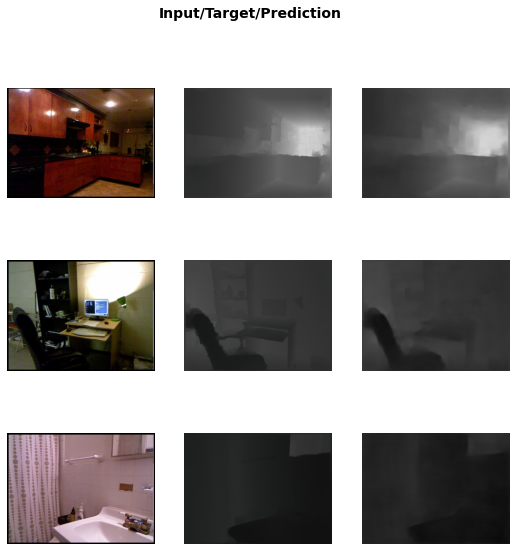

In [ ]:
learner.show_results()

### Qualitative Results testing
We can upload an image and run the model on it

/content
/content/images


Saving sunny.jpeg to sunny.jpeg
/content


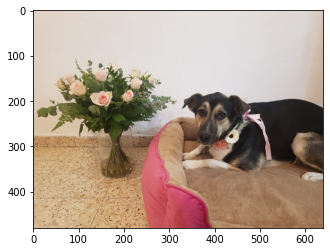

In [ ]:
%cd /content/
%mkdir images
%cd images

from google.colab import files
from io import BytesIO
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image


# Upload Image
uploaded = files.upload()
original = Image.open(BytesIO(uploaded[list(uploaded.keys())[0]]))

%cd /content/

original_shape = (original.shape[1],original.shape[0])
minified = original.resize((640,480))
minified_arr = np.array(minified)

plt.imshow(minified_arr)

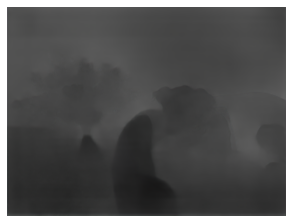

In [ ]:
predicted_depth_map = (learner.predict(minified_arr))[0]
show_image(predicted_depth_map)

In [ ]:
# Save our result
output = PILImageBW.create(predicted_depth_map).convert('L')
output = output.resize(original_shape)
output.save("images/" + list(uploaded.keys())[0].split('.')[0] + "_depth.png")